In [1]:
sampling_freq=125

In [2]:
# import (most of the) modules that we need
import time
import re
import os
from multiprocessing import Process
import numpy as np
import pylsl
from datetime import datetime
from nftools import guis
from nftools.mne import no_bad_samples, no_bad_channels, detect_channel_types
from nftools.threshold import find_mode, contiguous_regions, detect_bursts, determine_optimal_threshold
import mne
import dynarray
import pickle
from scipy import io as spio
import matplotlib.pyplot as plt

In [3]:
from pynfb.signal_processing.filters import (FilterSequence, 
                                             CFIRBandEnvelopeDetector, 
                                             ExponentialSmoother,
                                             SpatialFilter,
                                             ButterFilter,
                                             ButterBandEnvelopeDetector,
                                             ScalarButterFilter,
                                             MASmoother,
                                             FFTBandEnvelopeDetector,
                                             NotchFilter
                                            )

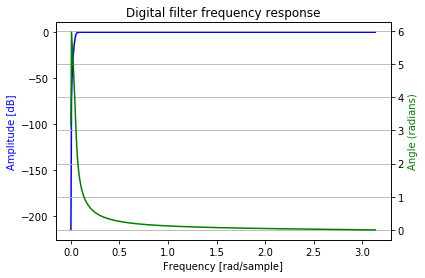

In [6]:
from scipy import signal
b = signal.firwin(80, 0.5, window=('kaiser', 8))
highpass_filter = ScalarButterFilter([1, None], sampling_freq)
w, h = signal.freqz(highpass_filter.filter.b, highpass_filter.filter.a)
# w, h = signal.freqz(b, 1)



import matplotlib.pyplot as plt
fig = plt.figure()
plt.title('Digital filter frequency response')
ax1 = fig.add_subplot(111)



plt.plot(w, 20 * np.log10(abs(h)), 'b')
plt.ylabel('Amplitude [dB]', color='b')
plt.xlabel('Frequency [rad/sample]')



ax2 = ax1.twinx()
angles = np.unwrap(np.angle(h))
plt.plot(w, angles, 'g')
plt.ylabel('Angle (radians)', color='g')
plt.grid()
plt.axis('tight')
plt.show()



# Checking the Lags of the filters we use

In [7]:
from pynfb.signal_processing.filters import (FilterSequence, 
                                             CFIRBandEnvelopeDetector, 
                                             ExponentialSmoother,
                                             SpatialFilter,
                                             ButterFilter,
                                             ButterBandEnvelopeDetector,
                                             ScalarButterFilter,
                                             MASmoother,
                                             FFTBandEnvelopeDetector,
                                             NotchFilter
                                            )

In [10]:
from scipy import signal
import matplotlib.pyplot as plt
def make_freq_response(b, a, sfreq, title, band):

    w, h = signal.freqz(b, a)



    import matplotlib.pyplot as plt
    fig = plt.figure()
    # plt.title('Digital filter frequency response')
    ax1 = fig.add_subplot(111)


    # make wf --> which is the frequency, not the pi stuff
    wf = w / 3.1415 * sfreq/2;
    
    plt.plot(wf, 20 * np.log10(abs(h)), 'b')
    plt.ylabel('Amplitude [dB]', color='b')
    plt.xlabel('Frequency [Hz]')

    # plt.xlim()
    # b, t = plt.ylim
    plt.vlines([12, 15], *plt.ylim(), color='r')
    


    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    plt.plot(wf, angles, 'g')
    plt.ylabel('Angle (radians)', color='g')
    plt.grid()
    plt.axis('tight')
    
    # calculate the delay in this band:
    phases = angles[np.logical_and(wf > 12, wf < 15)]
    phases = max(wf) - phases
    freqs = wf[np.logical_and(wf > 12, wf < 15)]

    1/freqs * phases / 2 / 3.1415
    
    
    # plt.title('{}, delay = {}'.format(title, delay))
    # plt.show()

In [11]:
w, h = signal.freqz(highpass_filter.filter.b, highpass_filter.filter.a)
wf = w / 3.1415 * 125/2;
angles = np.unwrap(np.angle(h))

In [12]:
phases = angles[np.logical_and(wf > 12, wf < 15)]

In [13]:
phases = max(wf) - phases

In [14]:
phases

array([62.16999923, 62.17223634, 62.17443043, 62.17658274, 62.17869451,
       62.18076691, 62.18280108, 62.18479809, 62.18675899, 62.18868479,
       62.19057647, 62.19243495, 62.19426114, 62.1960559 , 62.19782008,
       62.19955448, 62.20125988, 62.20293703, 62.20458667, 62.20620949,
       62.20780617, 62.20937738, 62.21092374, 62.21244586])

In [15]:
1/np.array([1,2,3])

array([1.        , 0.5       , 0.33333333])

In [16]:
sampling_freq = 125
band = [12, 15]

highpass_filter = ScalarButterFilter([3, None], sampling_freq)
bandpass_butter_filter = ButterFilter([12, 15], sampling_freq, 16)

In [126]:
plt.figure()
plt.subplot(2,1,1)
plt.plot(np.abs(env_filter_cfir.b))
plt.subplot(2,1,2)
plt.plot(np.angle(env_filter_cfir.b))

In [17]:
env_filter_cfir = CFIRBandEnvelopeDetector([12, 15], sampling_freq, MASmoother(round(sampling_freq/5)))
env_filter_butter = ButterBandEnvelopeDetector([12, 15], sampling_freq, MASmoother(round(sampling_freq/5)))
smoother = MASmoother(round(sampling_freq/5))
expsmoother = ExponentialSmoother(0.9)

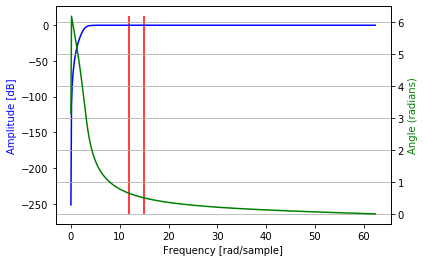

In [18]:
make_freq_response(highpass_filter.filter.b, highpass_filter.filter.a, sampling_freq, 'highpass filter', band)

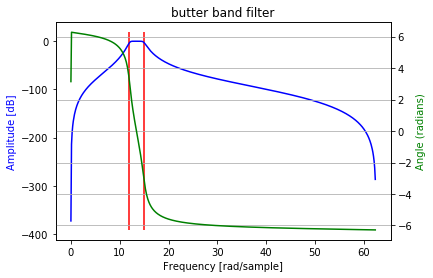

In [108]:
make_freq_response(bandpass_butter_filter.b, bandpass_butter_filter.a, sampling_freq, 'butter band filter', band)

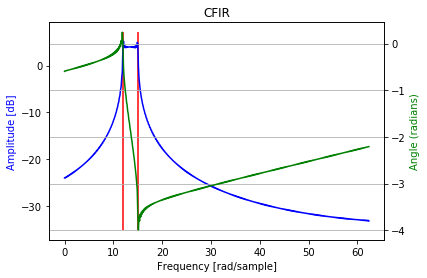

In [109]:
make_freq_response(env_filter_cfir.b, env_filter_cfir.a, sampling_freq, 'CFIR', band)

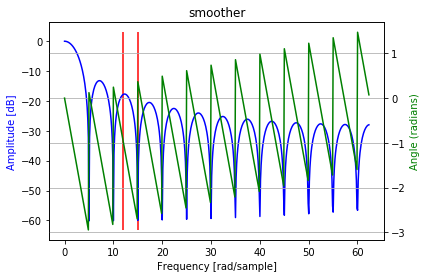

In [110]:
make_freq_response(smoother.b, smoother.a, sampling_freq, 'smoother', band)

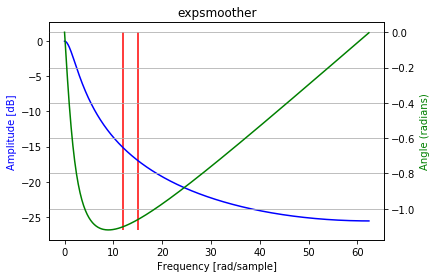

In [111]:
make_freq_response(expsmoother.b, expsmoother.a, sampling_freq, 'expsmoother', band)

In [25]:
# check lags with Actual Data:
m=np.loadtxt('/home/johan/data2.txt')

In [26]:
v=m[10,:]
%matplotlib qt

In [28]:

plt.plot(v)
import scipy.signal


In [41]:
plt.figure()
plt.plot(v)
plt.plot(v2)


In [140]:
plt.figure()

vorig = signal.filtfilt(highpass_filter.filter.b, highpass_filter.filter.a, v)
v1 = signal.filtfilt(bandpass_butter_filter.b, bandpass_butter_filter.a, vorig)
v2 = signal.lfilter(bandpass_butter_filter.b, bandpass_butter_filter.a, vorig)
plt.plot(np.arange(len(v1))/sampling_freq, vorig)
plt.plot(np.arange(len(v1))/sampling_freq, v1)
plt.plot(np.arange(len(v1))/sampling_freq, v2)
plt.legend(('orig', 'filtfilt (no delay)', 'lfilter'))
plt.xlabel('seconds')
estimate_lag(v1, v2)

In [142]:
plt.figure();
plt.plot(abs(v2));

In [70]:
plt.figure()

vorig = signal.filtfilt(bandpass_butter_filter.b, bandpass_butter_filter.a, v)
v1 = signal.filtfilt(highpass_filter.filter.b, highpass_filter.filter.a, vorig)
v2 = signal.lfilter(highpass_filter.filter.b, highpass_filter.filter.a, vorig)

plt.plot(np.arange(len(v1))/sampling_freq, vorig)
plt.plot(np.arange(len(v1))/sampling_freq, v1)
plt.plot(np.arange(len(v1))/sampling_freq, v2)

plt.legend(('orig', 'filtfilt (no delay)', 'lfilter'))
plt.xlabel('seconds')

Text(0.5, 0, 'seconds')

In [116]:
plt.figure()
highpass_filter = ScalarButterFilter([1, None], sampling_freq)

bandpass_butter_filter = ButterFilter([12, 15], sampling_freq, 16)
vorig = signal.filtfilt(bandpass_butter_filter.b, bandpass_butter_filter.a, v)
v1 = signal.filtfilt(highpass_filter.filter.b, highpass_filter.filter.a, vorig)
v2 = signal.lfilter(highpass_filter.filter.b, highpass_filter.filter.a, vorig)

plt.plot(np.arange(len(v1))/sampling_freq, vorig)
plt.plot(np.arange(len(v1))/sampling_freq, v1)
plt.plot(np.arange(len(v1))/sampling_freq, v2)

plt.legend(('orig', 'filtfilt (no delay)', 'lfilter'))
plt.xlabel('seconds')
plt.title('highpass filter')
estimate_lag(v1, v2)

In [137]:
plt.figure()
bandpass_butter_filter = ButterFilter([12, 15], sampling_freq, 16)
vorig = signal.filtfilt(bandpass_butter_filter.b, bandpass_butter_filter.a, v)
v1 = signal.filtfilt(env_filter_cfir.b, env_filter_cfir.a, vorig)
v2 = signal.lfilter(env_filter_cfir.b, env_filter_cfir.a, vorig)

plt.plot(np.arange(len(v1))/sampling_freq, vorig)
plt.plot(np.arange(len(v1))/sampling_freq, v1)
plt.plot(np.arange(len(v1))/sampling_freq, v2)

plt.legend(('orig', 'filtfilt (no delay)', 'lfilter'))
plt.xlabel('seconds')
plt.title('cFIR')

estimate_lag(v1, v2)

In [139]:
plt.figure()
plt.plot(abs(v2))


In [134]:
smoother = MASmoother(round(sampling_freq/5))
plt.figure()
bandpass_butter_filter = ButterFilter([12, 15], sampling_freq, 16)
vorig = np.abs(signal.filtfilt(bandpass_butter_filter.b, bandpass_butter_filter.a, v))
v1 = signal.filtfilt(smoother.b, smoother.a, vorig)
v2 = signal.lfilter(smoother.b, smoother.a, vorig)

plt.plot(np.arange(len(v1))/sampling_freq, vorig)
plt.plot(np.arange(len(v1))/sampling_freq, v1)
plt.plot(np.arange(len(v1))/sampling_freq, v2)

plt.legend(('orig', 'filtfilt (no delay)', 'lfilter'))
plt.xlabel('seconds')
plt.title('cFIR')

estimate_lag(v1, v2)

In [136]:
smoother = ExponentialSmoother(0.9)
plt.figure()
bandpass_butter_filter = ButterFilter([12, 15], sampling_freq, 16)
vorig = np.abs(signal.filtfilt(bandpass_butter_filter.b, bandpass_butter_filter.a, v))
v1 = signal.filtfilt(smoother.b, smoother.a, vorig)
v2 = signal.lfilter(smoother.b, smoother.a, vorig)

plt.plot(np.arange(len(v1))/sampling_freq, vorig)
plt.plot(np.arange(len(v1))/sampling_freq, v1)
plt.plot(np.arange(len(v1))/sampling_freq, v2)

plt.legend(('orig', 'filtfilt (no delay)', 'lfilter'))
plt.xlabel('seconds')
plt.title('cFIR')

estimate_lag(v1, v2)

In [110]:
def estimate_lag(v1, v2):

    av1 = np.abs(v1)
    av2 = np.abs(v2)
    
    bandpass_butter_filter = ButterFilter([None, 3], sampling_freq, 16)
    
    fav1 = signal.filtfilt(bandpass_butter_filter.b, bandpass_butter_filter.a, av1)
    fav2 = signal.filtfilt(bandpass_butter_filter.b, bandpass_butter_filter.a, av2)

    N=150
    corrs = []
    for i in range(N):
        vst = fav1[:-N]
        vd = fav2[i:-N+i]
        corrs.append(np.correlate(vst, vd))




    plt.figure(); plt.plot(np.arange(N)/sampling_freq, corrs)

    lag = np.where(corrs == max(corrs))[0][0]/sampling_freq

    plt.vlines(lag, *plt.ylim())

    lag = np.where(corrs == max(corrs))[0][0] / sampling_freq
    
    plt.title('lag: {:02f}'.format(lag))


In [98]:
lag = np.where(corrs == max(corrs))[0][0] / sampling_freq

0.128

In [81]:
plt.figure(); plt.plot(fav2)

In [62]:
np.arange(len(v1))

array([   0,    1,    2, ..., 1519, 1520, 1521])

In [49]:
plt.figure()
plt.plot(va)

In [50]:
plt.plot(vb)

In [34]:
# Define Filter Sequence for NF

# Which channel do we select for the EEG - we do C3.
rt_eeg_channels = ['C4']
rt_eeg_channels_mask = np.where([ch in rt_eeg_channels for ch in channel_names], 1, 0)/len(rt_eeg_channels)
eeg_channel_select = SpatialFilter(rt_eeg_channels_mask)
highpass_filter = ScalarButterFilter([3, None], sampling_freq)
butter_filter = ScalarButterFilter([12, 15], sampling_freq)

# eeg_notch_50 = NotchFilter(50, sampling_freq, len(channel_names))
# eeg_notch_25 = NotchFilter(25, sampling_freq, len(channel_names))

preprocess_filters_eeg = FilterSequence([
    ica_rejection,
    csp_rejection,
    eeg_channel_select,
    highpass_filter
    
])
envelope_filter_eeg = CFIRBandEnvelopeDetector([12, 15], sampling_freq, MASmoother(round(sampling_freq/5)))
butter_visualization_eeg = ButterFilter([12, 15], sampling_freq, 1)


# Processing of the EMG - this is basically our second channel...
rt_emg_channels = ['T3','T4','Fp1','Fp2']
# rt_emg_channels = ['T7','T8','TP9','TP10']
rt_emg_channels_mask = np.where([ch in rt_emg_channels for ch in channel_names], 1, 0)/len(rt_emg_channels)
emg_channel_select = SpatialFilter(rt_emg_channels_mask)

preprocess_filters_emg = FilterSequence([
    emg_channel_select,
])

envelope_filter_emg = ButterBandEnvelopeDetector([60, 62], sampling_freq, MASmoother(round(sampling_freq/5)))
butter_visualization_emg = ButterFilter([55, 60], sampling_freq, 1)

In [34]:
# Define Filter Sequence for NF

# Which channel do we select for the EEG - we do C3.
rt_eeg_channels = ['C4']
rt_eeg_channels_mask = np.where([ch in rt_eeg_channels for ch in channel_names], 1, 0)/len(rt_eeg_channels)
eeg_channel_select = SpatialFilter(rt_eeg_channels_mask)
highpass_filter = ScalarButterFilter([3, None], sampling_freq)
butter_filter = ScalarButterFilter([12, 15], sampling_freq)

# eeg_notch_50 = NotchFilter(50, sampling_freq, len(channel_names))
# eeg_notch_25 = NotchFilter(25, sampling_freq, len(channel_names))

preprocess_filters_eeg = FilterSequence([
    ica_rejection,
    csp_rejection,
    eeg_channel_select,
    highpass_filter
    
])
envelope_filter_eeg = CFIRBandEnvelopeDetector([12, 15], sampling_freq, MASmoother(round(sampling_freq/5)))
butter_visualization_eeg = ButterFilter([12, 15], sampling_freq, 1)


# Processing of the EMG - this is basically our second channel...
rt_emg_channels = ['T3','T4','Fp1','Fp2']
# rt_emg_channels = ['T7','T8','TP9','TP10']
rt_emg_channels_mask = np.where([ch in rt_emg_channels for ch in channel_names], 1, 0)/len(rt_emg_channels)
emg_channel_select = SpatialFilter(rt_emg_channels_mask)

preprocess_filters_emg = FilterSequence([
    emg_channel_select,
])

envelope_filter_emg = ButterBandEnvelopeDetector([60, 62], sampling_freq, MASmoother(round(sampling_freq/5)))
butter_visualization_emg = ButterFilter([55, 60], sampling_freq, 1)

In [34]:
# Define Filter Sequence for NF

# Which channel do we select for the EEG - we do C3.
rt_eeg_channels = ['C4']
rt_eeg_channels_mask = np.where([ch in rt_eeg_channels for ch in channel_names], 1, 0)/len(rt_eeg_channels)
eeg_channel_select = SpatialFilter(rt_eeg_channels_mask)
highpass_filter = ScalarButterFilter([3, None], sampling_freq)
butter_filter = ScalarButterFilter([12, 15], sampling_freq)

# eeg_notch_50 = NotchFilter(50, sampling_freq, len(channel_names))
# eeg_notch_25 = NotchFilter(25, sampling_freq, len(channel_names))

preprocess_filters_eeg = FilterSequence([
    ica_rejection,
    csp_rejection,
    eeg_channel_select,
    highpass_filter
    
])
envelope_filter_eeg = CFIRBandEnvelopeDetector([12, 15], sampling_freq, MASmoother(round(sampling_freq/5)))
butter_visualization_eeg = ButterFilter([12, 15], sampling_freq, 1)


# Processing of the EMG - this is basically our second channel...
rt_emg_channels = ['T3','T4','Fp1','Fp2']
# rt_emg_channels = ['T7','T8','TP9','TP10']
rt_emg_channels_mask = np.where([ch in rt_emg_channels for ch in channel_names], 1, 0)/len(rt_emg_channels)
emg_channel_select = SpatialFilter(rt_emg_channels_mask)

preprocess_filters_emg = FilterSequence([
    emg_channel_select,
])

envelope_filter_emg = ButterBandEnvelopeDetector([60, 62], sampling_freq, MASmoother(round(sampling_freq/5)))
butter_visualization_emg = ButterFilter([55, 60], sampling_freq, 1)